In [1]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Math, Latex

# print(plt.style.available)
plt.style.use('ggplot')

### Übungsblatt 5

#### 5.1 Hashfunktion djb2

Es soll die Hashfunktion `djb2` implementiert werden. Die dafür zu verwendende Funktion ist

$X_i := (a * X_{i-1}) + c_i$  (mod $M$)

mit den Parametern $X_0 = 5381$, $a = 33$ und $M = 2^{32}$.

In [2]:
def djb2(value, M=np.power(2, 32)):
    x_i = 5381
    for i in range(len(value)):
        char = value[i]
        x_i = ((33 * x_i) + ord(char)) % M
    return x_i

print('djb2 of "Hallo Welt": %d' % djb2('Hallo Welt'))

djb2 of "Hallo Welt": 2793804081


#### 5.2 Test Hash

Kollisionen:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

(6, ['TWILA'])
(13, ['AUDIE', 'LORRI'])
(17, ['ULRIKE'])
(20, ['ERICKA'])
(33, ['ALAN'])
(53, ['ALBA'])
(57, ['ALETHEA'])
(85, ['TAMIE'])
(91, ['MAMMIE'])
(94, ['ALEXANDRIA'])


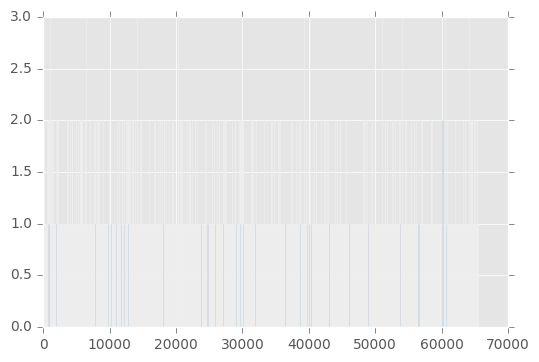

In [4]:
import matplotlib.mlab as mlab
from itertools import groupby

dht = {
    16: [],
    32: []
}

# hashes erstellen
with open('exercise5_names.txt', mode='r') as names:
    for name in names:
        name = name.strip()
        dht[16].append((djb2(name, np.power(2, 16)), name))
        dht[32].append((djb2(name), name))

# ausgabe der kollisionen
def group_hashes(dht):
    dht = sorted(dht, key=lambda k: k[0])
    result = []
    for k, g in groupby(dht, key=lambda k: k[0]):
        names = list(g)
        result.append((k, [n[1] for n in names]))
    return result

dht = {
    16: group_hashes(dht[16]),
    32: group_hashes(dht[32])
}

def count_hash_dups(dht):
    count = 0
    for _hash, names in dht:
        if len(names) > 1:
            count += 1
    return count

print('Kollisionen:')
display(Math(r'M = 2^{16}: %d' % count_hash_dups(dht[16])))
display(Math(r'M = 2^{32}: %d' % count_hash_dups(dht[32])))

for i in range(10):
    print(dht[16][i])

plt.bar([x[0] for x in dht[16]], [len(y[1]) for y in dht[16]])
plt.show()

#### 5.3 Distanzen $\Delta X$

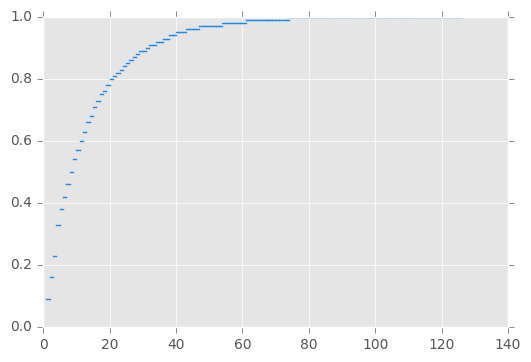

In [6]:
def ecdf(values):
    
    values = sorted(values)

    unique_values = sorted(list(set(values)))

    cumsum_values = []
    for u in unique_values:
        cumsum_values.append((u, len([1 for _ in values if _ <= u])))

    y = np.round([c / len(values) for t, c in cumsum_values], decimals=2)

    for i in range(len(unique_values)):
        x_0 = unique_values[i]
        x_1 = unique_values[i + 1] if i < len(unique_values) - 1 else unique_values[i] + 1
        plt.plot([x_0, x_1], [y[i], y[i]], color='#1e88e5', linestyle='-')


# distanzen zwischen den einzelnen hashes berechnen
distances = []
last_hash = -1
for h in dht[16]:
    current_hash = h[0]
    if last_hash is not -1:
        distances.append(current_hash - last_hash)
    last_hash = current_hash
#ecdf([h[0] for h in dht[16]])
ecdf(distances)

plt.show()